In [1]:
%matplotlib inline

## Predicting Survival on the Titanic

![](https://i.ytimg.com/vi/Wan0IJuXlys/maxresdefault.jpg)

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. 


Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

In [2]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the baseline model
from sklearn.linear_model import LogisticRegression

# to evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score

## Load the data set

In [3]:
df = pd.read_csv('../titanic_model/data/raw_titanic.csv')

# display data
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"



### Check for null, na values

In [4]:
df = df.replace('?', np.nan)
df.isnull().sum() #checking for total null values

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

### Get first letter of cabins

In [5]:
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
df['cabin'] = df['cabin'].apply(get_first_cabin)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Get passenger title

In [6]:
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

df['title'] = df['name'].apply(get_title)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON",Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs


### Drop `name`, `ticket`, `boat`, `body`, and `home.dest`

In [7]:
df.drop(labels=['name', 'ticket', 'boat', 'body',
                      'home.dest'], axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.55,C22,S,Master
2,1,0,female,2,1,2,151.55,C22,S,Miss
3,1,0,male,30,1,2,151.55,C22,S,Mr
4,1,0,female,25,1,2,151.55,C22,S,Mrs


### Check numerical types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    1309 non-null   int64 
 1   survived  1309 non-null   int64 
 2   sex       1309 non-null   object
 3   age       1046 non-null   object
 4   sibsp     1309 non-null   int64 
 5   parch     1309 non-null   int64 
 6   fare      1308 non-null   object
 7   cabin     295 non-null    object
 8   embarked  1307 non-null   object
 9   title     1309 non-null   object
dtypes: int64(4), object(6)
memory usage: 102.4+ KB


Since `age` and `fare` are floats, we need to convert them first before doing any predictive modeling.

In [9]:
df['fare'] = df['fare'].astype('float')
df['age'] = df['age'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


### Find numerical and categorical variables

In [10]:
target = 'survived'

In [11]:
vars_num = [c for c in df.columns if df[c].dtypes!='O' and c!=target]

vars_cat = [c for c in df.columns if df[c].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [12]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [13]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

### How many survived?

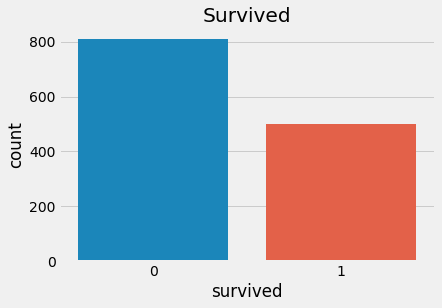

In [14]:
ax = sns.countplot('survived',data=df)
ax.set_title('Survived')
plt.show()

It's clear not that many survived, but let's break it down by gender, as you might have heard most women survied, lets find out.

### Breaking down by gender

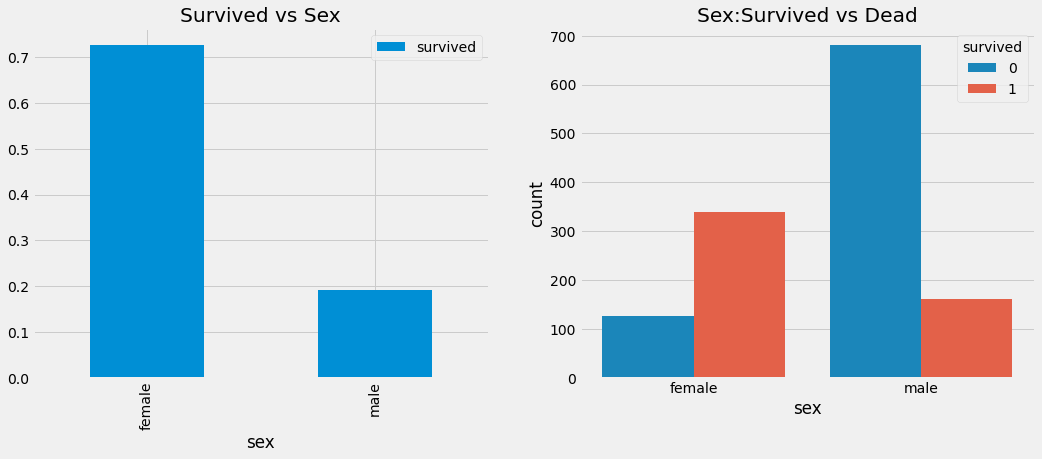

In [15]:
f,ax=plt.subplots(1,2,figsize=(16,6))
df[['sex','survived']].groupby(['sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('sex',hue='survived',data=df,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

While there were more men on the ship but lot more number of women survived, almost more than twice survived. Let's look at if socioeconomic class has anything to do with survive like in Titanic movie.

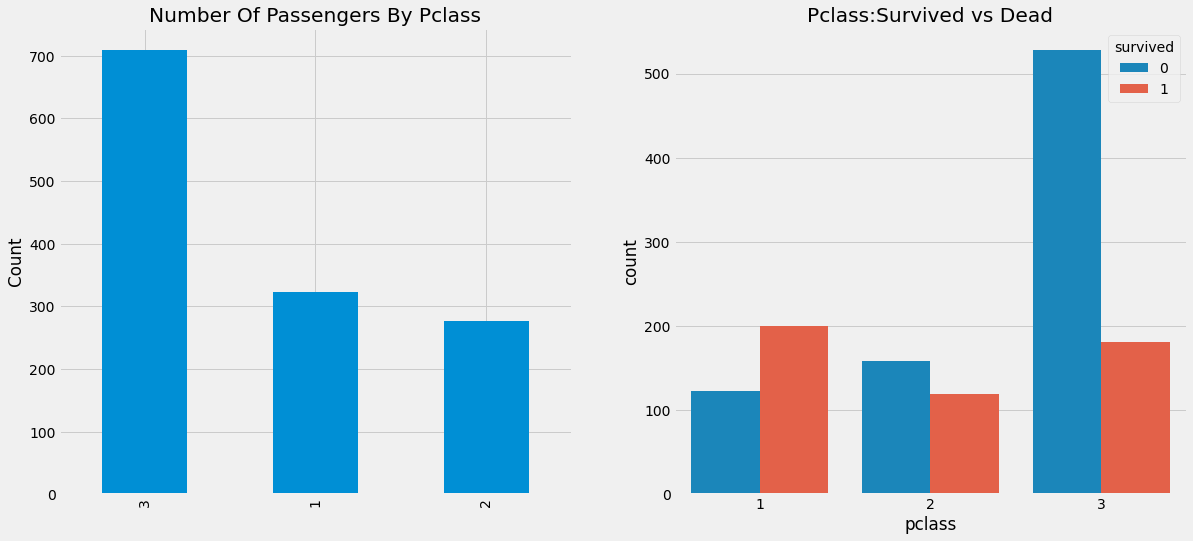

In [16]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('pclass',hue='survived',data=df,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

Looks like it did matter, clearly if you were of higher socioeconomic class your survival chances were higher.

### Fare vs. Pclass

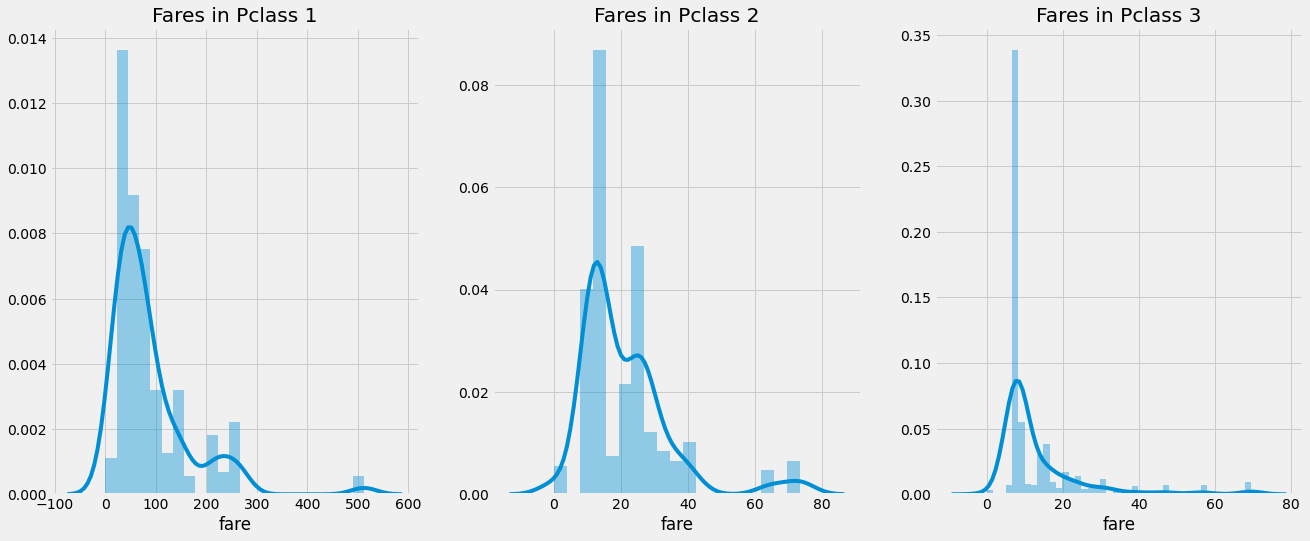

In [17]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(df[df['pclass']==1].fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(df[df['pclass']==2].fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(df[df['pclass']==3].fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

Just to be sure we can see how most of expensive tickets went to Pclass 1, while Pclass 2 and Plcass 3 where cheaper than them.

### Correlation matrix

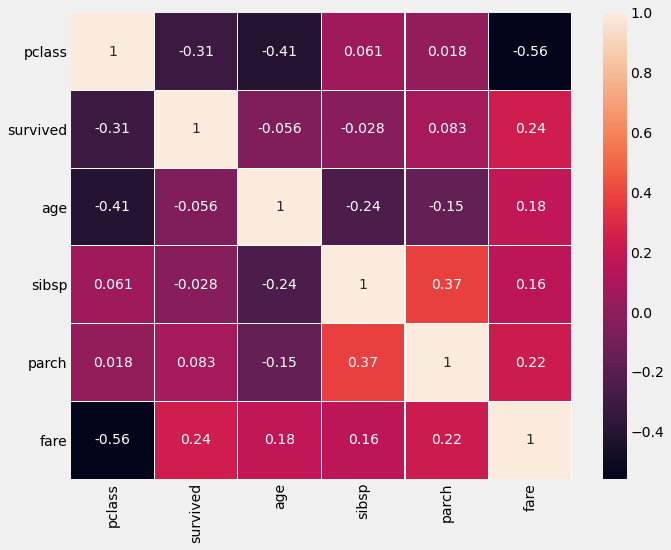

In [18]:
sns.heatmap(df.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

There is not much any signifcant correlation, highest is between `sibsp` and `parch`. 

## Separate data into train and test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('survived', axis=1),  # predictors
    df['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [20]:
X_train['cabin'] = X_train['cabin'].str[0] # captures the first letter
X_test['cabin'] = X_test['cabin'].str[0] # captures the first letter

X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [21]:
for var in ['age', 'fare']:

    # add missing indicator
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    # replace NaN by median
    median_val = X_train[var].median()
    print(var, median_val)

    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

X_train[['age', 'fare']].isnull().sum()

age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [22]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [23]:
temp = pd.Series(X_train["cabin"].value_counts() / len(X_train))
temp

Missing    0.766953
C          0.074499
B          0.049666
E          0.034384
D          0.034384
A          0.018147
F          0.017192
G          0.003820
T          0.000955
Name: cabin, dtype: float64

In [24]:
temp[temp >= 0.05]

Missing    0.766953
C          0.074499
Name: cabin, dtype: float64

In [25]:
temp[temp >= 0.05].index

Index(['Missing', 'C'], dtype='object')

In [26]:
list(temp[temp >= 0.05].index)

['Missing', 'C']

In [27]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    print(var)
    print(frequent_ls)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

sex
Index(['female', 'male'], dtype='object', name='sex')
cabin
Index(['C', 'Missing'], dtype='object', name='cabin')
embarked
Index(['C', 'Q', 'S'], dtype='object', name='embarked')
title
Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [28]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [29]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [30]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

### Scale the variables

- Use the standard scaler from Scikit-learn

In [31]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [32]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [33]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431723338485316
train accuracy: 0.7125119388729704

test roc-auc: 0.7404012345679012
test accuracy: 0.683206106870229

